# New York City Taxi Trip Duration

The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should **predict the duration of each trip in the test set.**

### File descriptions

**train.csv** - the training set (contains 1458644 trip records)  
**test.csv** - the testing set (contains 625134 trip records)  
**sample_submission.csv** - a sample submission file in the correct format

## Table of Contents:
**[I. Data loading and overview](#one)**
- [a. Loading the data](#one-a)
- [b. Overview](#one-b)

**[II. Data cleaning](#two)**
- [a. Duplicated and missing values](#two-a)
- [b. Deal with outliers](#two-b)

**[III. Features engineering](#three)**
- [a. Target](#three-a)
- [b. Deal with categorical features](#three-b)
- [c. Deal with dates](#three-c)
- [d. Distance and speed creations](#three-d)
- [e. Correlations and dimensionality reductions](#three-e)

**[IV. Model selection](#four)**
- [a. Split](#four-a)
- [b. Metrics](#four-b)
- [c. Models](#four-c)
- [d. Cross-validation](#four-d)

**[V. Hyperparameters tuning](#five)**

**[VI. Training and predictions](#six)**

## I. Data loading and overview <a id="one"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

### a. Loading the data <a id="one-a"></a>

In [2]:
FILEPATH = "data/"
df = pd.read_csv(FILEPATH + "train.csv")
test = pd.read_csv(FILEPATH + "test.csv")

In [3]:
df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
test.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


### b. Overview <a id="one-b"></a>

Colonne | Description
------- | -------
**id** | a unique identifier for each trip  
**vendor_id** | a code indicating the provider associated with the trip record  
**pickup_datetime** | date and time when the meter was engaged  
**dropoff_datetime** | date and time when the meter was disengaged  
**passenger_count** | the number of passengers in the vehicle (driver entered value)  
**pickup_longitude** | the longitude where the meter was engaged  
**pickup_latitude** | the latitude where the meter was engaged  
**dropoff_longitude** | the longitude where the meter was disengaged  
**dropoff_latitude** | the latitude where the meter was disengaged  
**store_and_fwd_flag** | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)  
**trip_duration** | duration of the trip in seconds  

*Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.*

In [5]:
df.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134

## II. Data cleaning <a id="two"></a>

### a. Duplicated and missing values <a id="two-a"></a>

In [6]:
#Count the number of duplicated rows
df.duplicated().sum()

0

In [7]:
#Count the number of NaN values for each column
df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no duplicated or missing values.

### b. Deal with outliers <a id="two-b"></a>

In [8]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


We clearly see `trip_duration` takes strange values for `min` and `max`. Let's have a quick visualization with a boxplot.

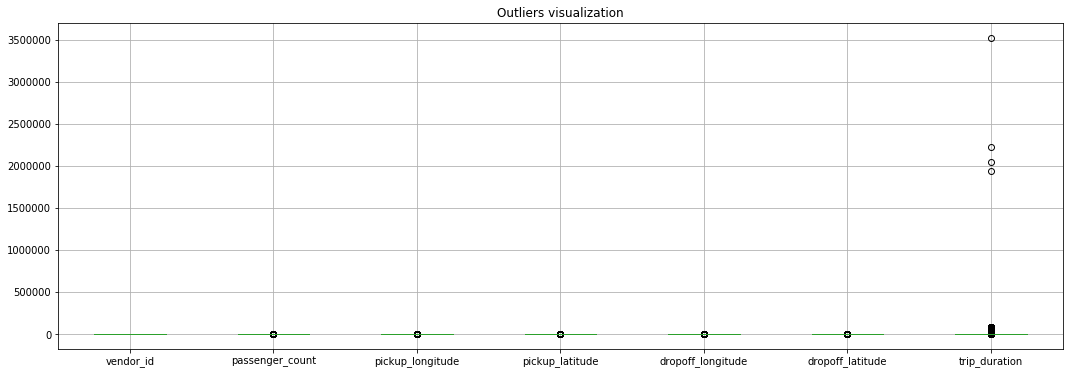

In [9]:
#Visualize univariate outliers
plt.subplots(figsize=(18,6))
plt.title("Outliers visualization")
df.boxplot();

There are outliers for `trip_duration`. I can't find a proper interpretation and it will probably damage our model, so I choose to get rid of them.

In [10]:
#Only keep trips that lasted less than 6000 seconds
df = df[(df.trip_duration < 6000)]

In [11]:
#Only keep trips with passengers
df = df[(df.passenger_count > 0)]

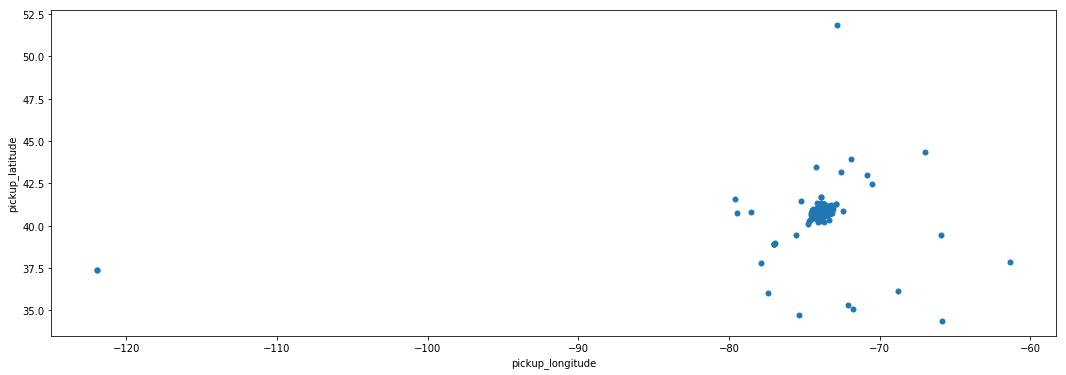

In [12]:
#Plot pickup positions to visualize outliers
pickup_longitude = list(df.pickup_longitude)
pickup_latitude = list(df.pickup_latitude)
plt.subplots(figsize=(18,6))
plt.plot(pickup_longitude, pickup_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.show()

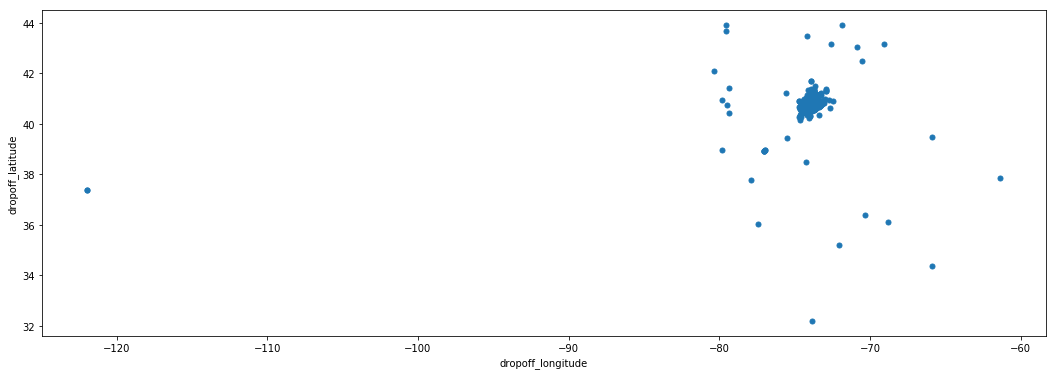

In [13]:
#Plot dropoff positions to visualize outliers
dropoff_longitude = list(df.dropoff_longitude)
dropoff_latitude = list(df.dropoff_latitude)
plt.subplots(figsize=(18,6))
plt.plot(dropoff_longitude, dropoff_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.show()

In [14]:
#Remove position outliers
df = df[(df.pickup_longitude > -100)]
df = df[(df.pickup_latitude < 50)]
#df = df[(df.dropoff_longitude < -70) & (df.dropoff_longitude > -80)]
#df = df[(df.dropoff_latitude < 50)]

## III. Features engineering <a id="three"></a>

### a. Target <a id="three-a"></a>

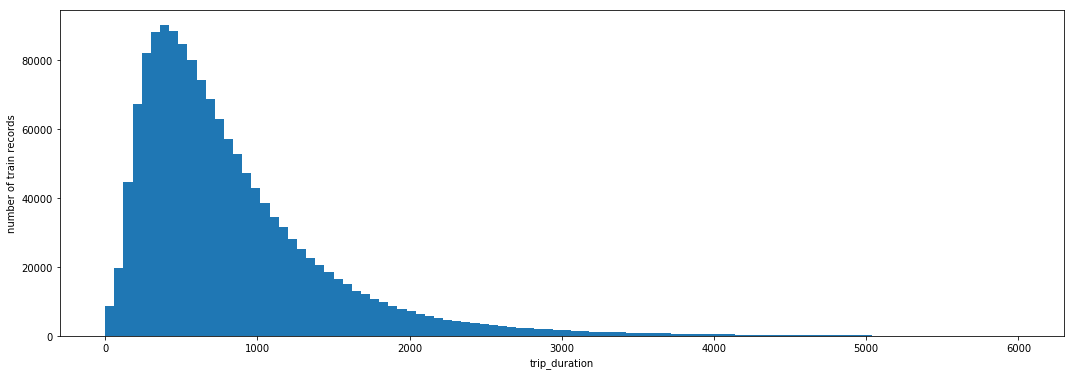

In [15]:
#Visualize the distribution of trip_duration values
plt.subplots(figsize=(18,6))
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

The distribution is **right-skewed** so we can consider a log-transformation of `trip_duration` column.

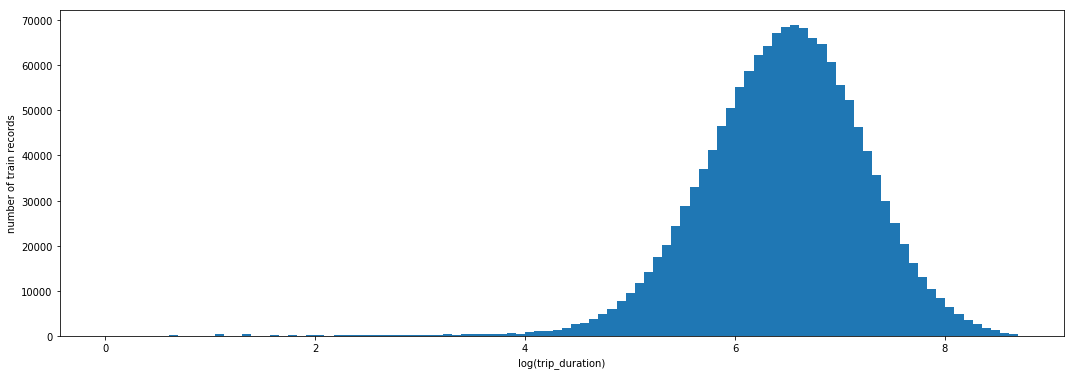

In [16]:
#Log-transformation
plt.subplots(figsize=(18,6))
df['trip_duration'] = np.log(df['trip_duration'].values)
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

### b. Deal with categorical features <a id="three-b"></a>

In [17]:
#One-hot encoding binary categorical features
df = pd.concat([df, pd.get_dummies(df['store_and_fwd_flag'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['store_and_fwd_flag'])], axis=1)

df.drop(['store_and_fwd_flag'], axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['vendor_id'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['vendor_id'])], axis=1)

df.drop(['vendor_id'], axis=1, inplace=True)

### c. Deal with dates <a id="three-c"></a>

In [18]:
#Datetyping the dates
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

df.drop(['dropoff_datetime'], axis=1, inplace=True) #as we don't have this feature in the testset

#Date features creations and deletions
df['month'] = df.pickup_datetime.dt.month
df['week'] = df.pickup_datetime.dt.week
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour
df['minute'] = df.pickup_datetime.dt.minute
df['minute_oftheday'] = df['hour'] * 60 + df['minute']
df.drop(['minute'], axis=1, inplace=True)

test['month'] = test.pickup_datetime.dt.month
test['week'] = test.pickup_datetime.dt.week
test['weekday'] = test.pickup_datetime.dt.weekday
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test['minute_oftheday'] = test['hour'] * 60 + test['minute']
test.drop(['minute'], axis=1, inplace=True)

df.drop(['pickup_datetime'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456015 entries, 0 to 1458643
Data columns (total 16 columns):
id                   1456015 non-null object
passenger_count      1456015 non-null int64
pickup_longitude     1456015 non-null float64
pickup_latitude      1456015 non-null float64
dropoff_longitude    1456015 non-null float64
dropoff_latitude     1456015 non-null float64
trip_duration        1456015 non-null float64
N                    1456015 non-null uint8
Y                    1456015 non-null uint8
1                    1456015 non-null uint8
2                    1456015 non-null uint8
month                1456015 non-null int64
week                 1456015 non-null int64
weekday              1456015 non-null int64
hour                 1456015 non-null int64
minute_oftheday      1456015 non-null int64
dtypes: float64(5), int64(6), object(1), uint8(4)
memory usage: 150.0+ MB


### d. Distance and speed creations <a id="three-d"></a>

In [19]:
%%time
#Distance calculation function
from math import sin, cos, sqrt, atan2, radians

def calculateDistance(row):
    R=6373.0 # approximate radius of earth in km
    pickup_lat=radians(row['pickup_latitude'])
    pickup_lon=radians(row['pickup_longitude'])
    dropoff_lat=radians(row['dropoff_latitude'])
    dropoff_lon=radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

#Add distance feature
df['distance'] = df.apply(lambda row:calculateDistance(row),axis=1)
test['distance'] = test.apply(lambda row:calculateDistance(row),axis=1)

df.head(2)

CPU times: user 1min 28s, sys: 1.33 s, total: 1min 29s
Wall time: 1min 33s


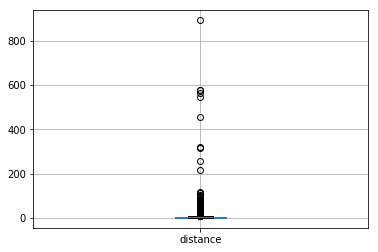

In [20]:
#Visualize distance outliers
df.boxplot(column='distance', return_type='axes');

In [21]:
#Remove distance outliers
df = df[(df.distance < 400)]

In [22]:
#Create speed feature
df['speed'] = df.distance / df.trip_duration

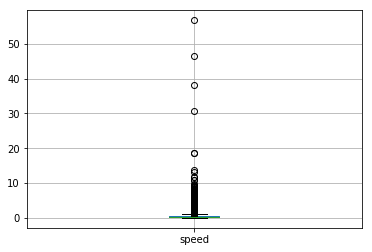

In [23]:
#Visualize speed feature
df.boxplot(column='speed', return_type='axes');

In [ ]:
#Remove speed outliers
df = df[(df.speed < 50)]
df.drop(['speed'], axis=1, inplace=True)

### e. Correlations and dimensionality reductions <a id="three-e"></a>

In [ ]:
#Correlations between variables
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

## IV. Model selection <a id="four"></a>

### a. Split <a id="four-a"></a>

In [ ]:
#Split the labeled data frame into two sets: features and target
y = df["trip_duration"]
df.drop(["trip_duration"], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)
X = df

X.shape, y.shape

In [ ]:
#Split the labeled data frame into two sets to train then test the models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

### b. Metrics <a id="four-b"></a>

For this specific problematic, we'll measure the error using the MSE (Mean Squared Error).

In [ ]:
from sklearn.metrics import mean_squared_error as MSE

### c. Models <a id="four-c"></a>

In [ ]:
#from sklearn.ensemble import GradientBoostingRegressor

#gb = GradientBoostingRegressor()
#gb.fit(X_train, y_train)
#print(gb.score(X_train, y_train), gb.score(X_test, y_test))
#print(np.sqrt(MSE(y_test, gb.predict(X_test))))

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train), rf.score(X_test, y_test))
print(np.sqrt(MSE(y_test, rf.predict(X_test))))

RandomForestRegressor seems to be the best model.

### d. Cross-validation <a id="four-d"></a>

In [ ]:
#from sklearn.model_selection import cross_val_score

#cv_score = cross_val_score(rf, X_train, y_train, cv=5)
#print(cv_score)
#print(np.mean(cv_score))

The model using RandomForestRegressor is stable.

## V. Hyperparameters tuning <a id="five"></a>

In [ ]:
#from sklearn.model_selection import RandomizedSearchCV

#n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 16)]
#max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]
#bootstrap = [True, False]

#random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

#random_cv = RandomizedSearchCV(estimator = m1, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#print(random_cv.best_params_)

## VI. Training and predictions <a id="six"></a>

In [ ]:
#Training on all labeled data using the best parameters found in hyperparameters tuning
rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, min_samples_split=15, max_features='auto', max_depth=90, bootstrap=True)
rf.fit(X, y)

In [ ]:
test_columns = X.columns
predictions = rf.predict(test[test_columns])

In [ ]:
submission = pd.DataFrame({'id': test.id, 'trip_duration': np.exp(predictions)})
submission.head()

In [ ]:
submission.to_csv(FILEPATH + "submission1.csv", index=False)